In [149]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

from IPython.display import Image
from subprocess import call

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')
from features import *
from utils import *

In [2]:
mbit_rate = 1/125000

fp_240 = '../data/240p/' 
fp_360 = '../data/360p/' 
fp_480 = '../data/480p/'
fp_720 = '../data/720p/'
fp_1080 = '../data/1080p/' 

In [3]:
dfs_240 = []
for file in os.listdir(fp_240):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_240.append(pd.read_csv(fp_240+file))
    
dfs_360 = []
for file in os.listdir(fp_360):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_360.append(pd.read_csv(fp_360+file))
        
dfs_480 = []
for file in os.listdir(fp_480):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_480.append(pd.read_csv(fp_480+file))
        
dfs_720 = []
for file in os.listdir(fp_720):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_720.append(pd.read_csv(fp_720+file))

dfs_1080 = []
for file in os.listdir(fp_1080):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        dfs_1080.append(pd.read_csv(fp_1080+file))

In [4]:
ms_240 = []
for df in dfs_240:
    ms_240.append(convert_ms_df(df,True))
    
ms_360 = []
for df in dfs_360:
    ms_360.append(convert_ms_df(df,True))
    
ms_480 = []
for df in dfs_480:
    ms_480.append(convert_ms_df(df,True))
    
ms_720 = []
for df in dfs_720:
    ms_720.append(convert_ms_df(df,True))
    
ms_1080 = []
for df in dfs_1080:
    ms_1080.append(convert_ms_df(df,True))

In [5]:
resamples_240 = []
for df in ms_240:
    resamples_240.append(df.resample('500ms', on='Time').sum())
    
resamples_360 = []
for df in ms_360:
    resamples_360.append(df.resample('500ms', on='Time').sum())
    
resamples_480 = []
for df in ms_480:
    resamples_480.append(df.resample('500ms', on='Time').sum())
    
resamples_720 = []
for df in ms_720:
    resamples_720.append(df.resample('500ms', on='Time').sum())
    
resamples_1080 = []
for df in ms_1080:
    resamples_1080.append(df.resample('500ms', on='Time').sum())

In [6]:
## take the aggregate features of the whole chunk; download and upload
def agg_feat(df, col):
    return [np.mean(df[col]), np.std(df[col])]

## take the ratio of upload:download packets
def pkt_ratio(df):
    ms_df = convert_ms_df(df, True)
    local = np.sum(ms_df['pkt_src'] == '1') 
    server = np.sum(ms_df['pkt_src'] == '2') 
    return local / server

## take the ratio of upload:download bytes
def bytes_ratio(df):
    local = df['1->2Bytes'].sum()
    server = df['2->1Bytes'].sum()
    return local / server

In [7]:
## finds the peaks with mean + 2(1) std
## run the above aggregate functions on the peaks only??

def get_peak_loc(df, col, invert=False):
    'invert arg allows you to get values not considered peaks'
    df_avg = df[col].mean()
    df_std = df[col].std()
  
    threshold = df_avg + (1 * df_std)
  
    if invert:
        return np.array(df[col] < threshold)
  
    else:
        return np.array(df[col] > threshold)

## np.mean, np.var, np.std - think of more?  
def peak_time_diff(df, col):
    '''
    mess around with the different inputs for function. 
    variance seems to inflate the difference betweent the two the most with litte
    to no data manipulation. however, currently trying things like
    squaring the data before taking the aggregate function to exaggerate
    differences (moderate success??)
    '''
    peaks = df[get_peak_loc(df, col)]
    peaks['Time'] = peaks['Time'] - peaks['Time'].min()
    time_diff = np.diff(peaks['Time'] ** 2)
    return [np.mean(time_diff), np.var(time_diff), np.std(time_diff)]

In [8]:
from scipy.signal import find_peaks

def peak_times(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    if list(peaks) == []:
        return [-1]
    times = df.iloc[peaks]['Time'].values
    time_between_peaks = [times[i]-times[i-1]for i in range(1,len(times))]
    #print(time_between_peaks)
    #time_between_peaks[0]=0
    if time_between_peaks == []:
        return -1
    return time_between_peaks

def num_peaks(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    return len(peaks)

In [9]:
def spectral_features(df, col):
    """
    welch implemention of spectral features
    resample the data before inputting (might change prereq depending on
    resource allocation)
    """
    f, Pxx_den = sp.signal.welch(df[col], fs=2)
    Pxx_den = np.sqrt(Pxx_den)

    peaks = sp.signal.find_peaks(Pxx_den)[0]
    prominences = sp.signal.peak_prominences(Pxx_den, peaks)[0]

    idx_max = prominences.argmax()
    loc_max = peaks[idx_max]

    return [f[loc_max], Pxx_den[loc_max], prominences[idx_max]]

In [10]:
def chunk_data(df, interval=60):
    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """
    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [11]:
def create_features(dfs, interval=60):

    features = [
    'dwl_peak_freq',
    'dwl_peak_prom',
    'dwl_max_psd',
    'dwl_bytes_avg',
    'dwl_bytes_std',
    'dwl_peak_avg',
    'dwl_peak_var',
    'dwl_peak_std',
    'upl_peak_freq',
    'upl_peak_prom',
    'upl_max_psd',
    'upl_bytes_avg',
    'upl_bytes_std',
    'upl_peak_avg',
    'upl_peak_var',
    'upl_peak_std',
    'dwl_time_peak',#'IMAN_up_time_peak',
      'dwl_num_peak'#,'IMAN_up_num_peak'
    ]  

    vals = []
    for df in dfs:
        df_chunks = chunk_data(df, interval)

        for chunk in df_chunks:

            preproc = convert_ms_df(chunk, True)
            upl_bytes = preproc[preproc['pkt_src'] == '1'].resample('500ms', on='Time').sum()
            dwl_bytes = preproc[preproc['pkt_src'] == '2'].resample('500ms', on='Time').sum()

            ## spectral features
            dwl_spectral = spectral_features(dwl_bytes, 'pkt_size')
            upl_spectral = spectral_features(upl_bytes, 'pkt_size')

            ## aggregate features
            dwl_agg = agg_feat(chunk, '2->1Bytes')
            upl_agg = agg_feat(chunk, '1->2Bytes')

            ## peak features
            dwl_peak = peak_time_diff(chunk, '2->1Bytes')
            upl_peak = peak_time_diff(chunk, '1->2Bytes')

            ## iman's time between peak 
            iman_dwn_time_peak = np.mean(peak_times(chunk,'2->1Bytes',1000000))
            #iman_up_time_peak = np.mean(peak_times(chunk,'1->2Bytes',50000))

            ## iman's num peak
            iman_dwn_num_peak = num_peaks(chunk,'2->1Bytes',1000000)
            #iman_up_num_peak = num_peaks(chunk,'1->2Bytes',50000)



            feat_val = np.hstack((
              dwl_spectral,
              dwl_agg,
              dwl_peak,
              upl_spectral,
              upl_agg,
              upl_peak,
                iman_dwn_time_peak,#iman_up_time_peak,
                iman_dwn_num_peak,#iman_up_num_peak
            ))

            vals.append(feat_val)
    
    return pd.DataFrame(columns=features, data=vals).fillna(0)

In [40]:
feat_240 = create_features(dfs_240, 120)
feat_360 = create_features(dfs_360, 120)
feat_480 = create_features(dfs_480, 120)
feat_720 = create_features(dfs_720, 120)
feat_1080 = create_features(dfs_1080, 120)

In [41]:
feat_240['resolution'] = np.zeros(len(feat_240))
feat_360['resolution'] = np.zeros(len(feat_360)) + 1
feat_480['resolution'] = np.zeros(len(feat_480)) + 2
feat_720['resolution'] = np.zeros(len(feat_720)) + 3
feat_1080['resolution'] = np.zeros(len(feat_1080)) + 4

In [42]:
data = pd.concat([feat_240, feat_360, feat_480, feat_720, feat_1080]).reset_index(drop=True)
data = data[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std','resolution']]
data

,dwl_bytes_avg,dwl_peak_prom,upl_bytes_std,dwl_bytes_std,upl_peak_std,resolution
0,105818.018349,3.172323e+05,16862.760631,292073.412690,980.253668,0.0
1,56392.975904,2.116595e+05,9105.882828,181129.552286,1420.062049,0.0
2,51312.250000,2.252769e+05,10219.868095,203432.423015,2320.069602,0.0
3,39377.755319,1.933348e+05,7590.302042,151199.194042,1367.217378,0.0
4,63535.761905,1.908308e+05,9625.049335,191208.720401,1348.799970,0.0
...,...,...,...,...,...,...
182,233169.513514,1.295016e+06,27193.069522,569860.008211,666.245992,4.0
183,228929.241379,1.164929e+06,24587.033458,516817.245537,1546.366790,4.0
184,203555.510204,7.298143e+05,26150.031304,546653.912209,904.036526,4.0
185,248339.244444,9.803294e+05,27889.468266,588179.115896,749.898155,4.0


## Preprocessing

In [76]:
scaler = StandardScaler()
for feat in data.columns:
    if feat == "resolution":
        continue
    data[feat] = scaler.fit_transform(np.array(data[feat]).reshape(-1, 1))

In [109]:
X, y = data.drop(columns=['resolution']), data['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=data['resolution'])

## Model

In [128]:
classifier = RandomForestClassifier(n_estimators = 8, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=8, random_state=42)

In [129]:
y_pred = classifier.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Actual Group'], colnames=['Predicted Group'])

Predicted Group,0.0,1.0,2.0,3.0,4.0
Actual Group,,,,,
0.0,9,0,0,0,0
1.0,0,9,1,0,0
2.0,0,2,7,0,0
3.0,0,1,0,5,3
4.0,0,0,0,3,7


In [130]:
f1_score(y_test, y_pred, average=None)

array([1.        , 0.81818182, 0.82352941, 0.58823529, 0.7       ])

In [131]:
accuracy_score(y_test, y_pred)

0.7872340425531915

In [39]:
features = ['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std']
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])
    

dwl_bytes_avg :  0.3669071707104034
dwl_peak_prom :  0.26870787868314416
dwl_bytes_std :  0.19899207692976834
upl_bytes_std :  0.10312775070051826
upl_peak_std :  0.06226512297616585


In [123]:
rf_clf = RandomForestClassifier()
parameters_rf = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"], 
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}

grid_rf = GridSearchCV(rf_clf, parameters_rf, scoring=make_scorer(accuracy_score))
grid_rf.fit(X_train, y_train)

rf_clf = grid_rf.best_estimator_

rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)

print("The Score for Random Forest is: " + str(acc_rf))

The Score for Random Forest is: 0.851063829787234


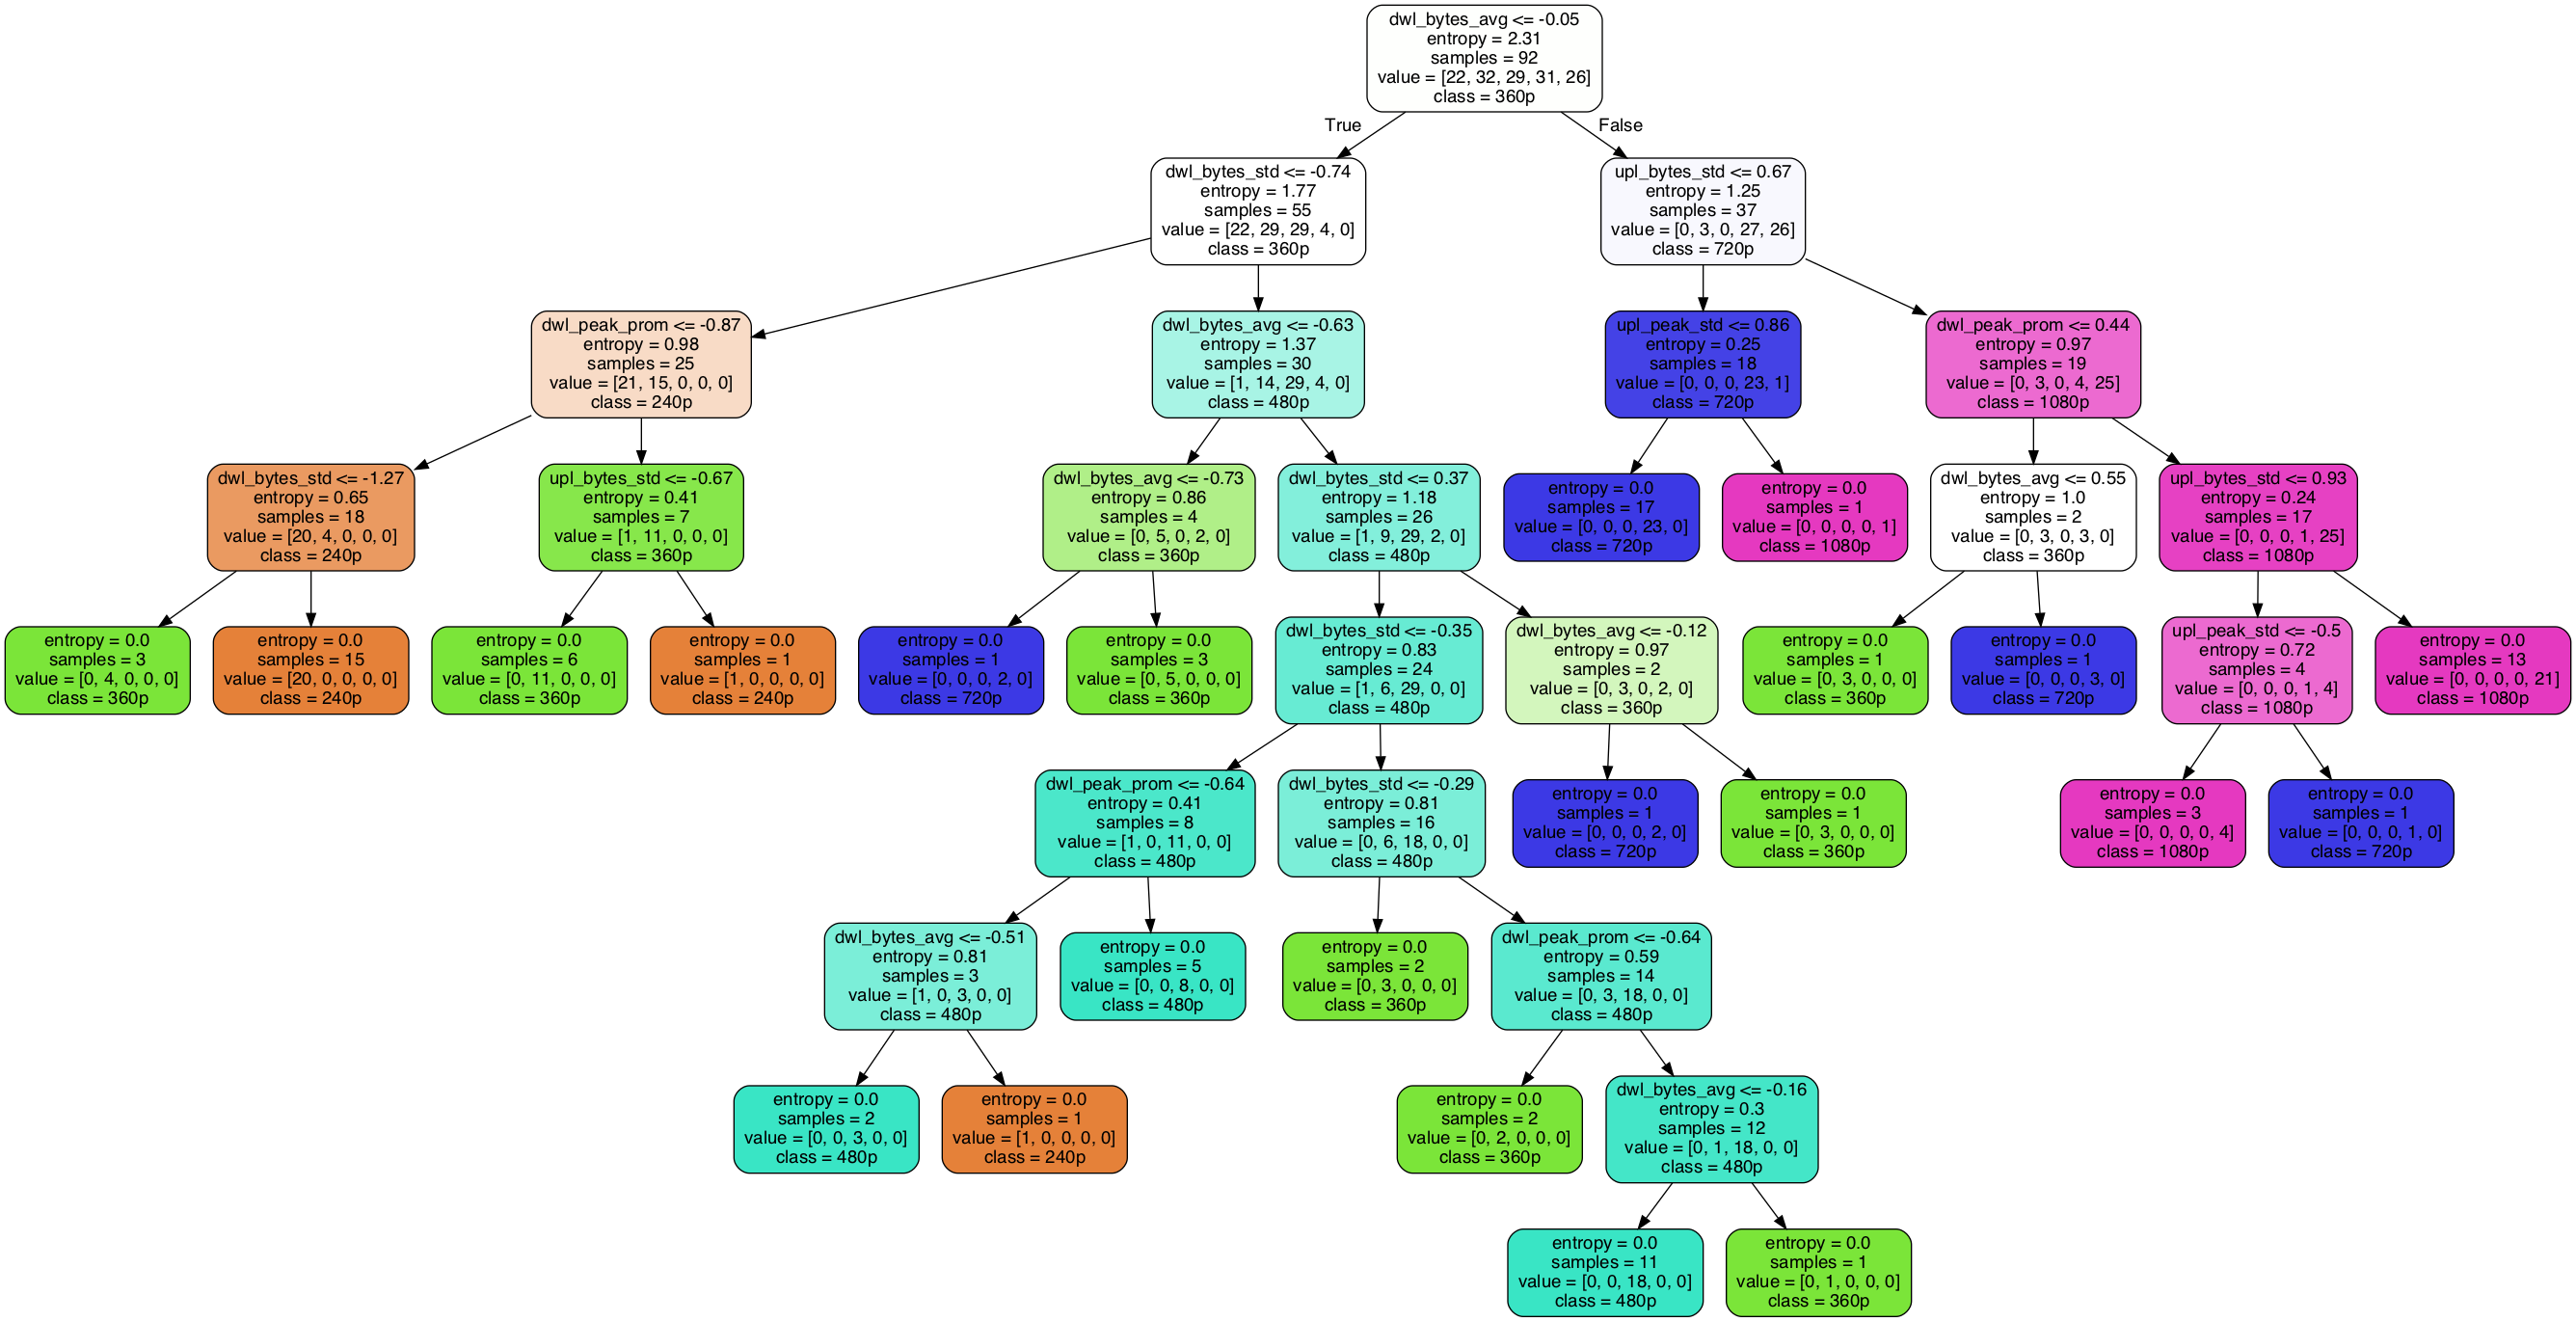

In [142]:
estimator = rf_clf.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = ["240p", "360p", "480p", "720p", "1080p"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

os.system('dot -Tpng tree.dot -o tree.png')
Image(filename = 'tree.png')

In [152]:
explanations_path = "../model/rf_visualization"
for i in tqdm(range(len(rf_clf.estimators_))):
    
    estimator = rf_clf.estimators_[i]
    export_graphviz(estimator, out_file=os.path.join(explanations_path, 'tree{}.dot'.format(i+1)), 
                    feature_names = features,
                    class_names = ["240p", "360p", "480p", "720p", "1080p"],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    os.system('dot -Tpng {} -o {}'.format(os.path.join(explanations_path, 'tree{}.dot'.format(i+1)),
                                           os.path.join(explanations_path, 'tree{}.png'.format(i+1))))

100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


## Model Experimentation

In [121]:
svc_clf = SVC() 

parameters_svc = {"kernel": ["rbf", "linear"], "probability": [True, False], "verbose": [True, False]}

grid_svc = GridSearchCV(svc_clf, parameters_svc, scoring=make_scorer(accuracy_score))
grid_svc.fit(X_train, y_train)

svc_clf = grid_svc.best_estimator_

svc_clf.fit(X_train, y_train)
pred_svc = svc_clf.predict(X_test)
acc_svc = accuracy_score(y_test, pred_svc)
print("The Score for SVC is: " + str(acc_svc))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]The Score for SVC is: 0.6595744680851063


In [122]:
linsvc_clf = LinearSVC()

parameters_linsvc = {"multi_class": ["ovr", "crammer_singer"], "fit_intercept": [True, False], "max_iter": [100, 500, 1000, 1500]}

grid_linsvc = GridSearchCV(linsvc_clf, parameters_linsvc, scoring=make_scorer(accuracy_score))
grid_linsvc.fit(X_train, y_train)

linsvc_clf = grid_linsvc.best_estimator_

linsvc_clf.fit(X_train, y_train)
pred_linsvc = linsvc_clf.predict(X_test)
acc_linsvc = accuracy_score(y_test, pred_linsvc)

print("The Score for LinearSVC is: " + str(acc_linsvc))

The Score for LinearSVC is: 0.7021276595744681


In [124]:
logreg_clf = LogisticRegression()

parameters_logreg = {"penalty": ["l2"], "fit_intercept": [True, False], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                     "max_iter": [50, 100, 200], "warm_start": [True, False]}

grid_logreg = GridSearchCV(logreg_clf, parameters_logreg, scoring=make_scorer(accuracy_score))
grid_logreg.fit(X_train, y_train)

logreg_clf = grid_logreg.best_estimator_

logreg_clf.fit(X_train, y_train)
pred_logreg = logreg_clf.predict(X_test)
acc_logreg = accuracy_score(y_test, pred_logreg)

print("The Score for Logistic Regression is: " + str(acc_logreg))

The Score for Logistic Regression is: 0.6382978723404256


In [125]:
knn_clf = KNeighborsClassifier()

parameters_knn = {"n_neighbors": [3, 5, 10, 15], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree"],
                  "leaf_size": [20, 30, 50]}

grid_knn = GridSearchCV(knn_clf, parameters_knn, scoring=make_scorer(accuracy_score))
grid_knn.fit(X_train, y_train)

knn_clf = grid_knn.best_estimator_

knn_clf.fit(X_train, y_train)
pred_knn = knn_clf.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)

print("The Score for KNeighbors is: " + str(acc_knn))

The Score for KNeighbors is: 0.7872340425531915


In [132]:
gnb_clf = GaussianNB()

parameters_gnb = {}

grid_gnb = GridSearchCV(gnb_clf, parameters_gnb, scoring=make_scorer(accuracy_score))
grid_gnb.fit(X_train, y_train)

gnb_clf = grid_gnb.best_estimator_

gnb_clf.fit(X_train, y_train)
pred_gnb = gnb_clf.predict(X_test)
acc_gnb = accuracy_score(y_test, pred_gnb)

print("The Score for Gaussian NB is: " + str(acc_gnb))

The Score for Gaussian NB is: 0.723404255319149


In [133]:
from xgboost import XGBClassifier

xg_clf = XGBClassifier()

parameters_xg = {"objective" : ["reg:linear"], "n_estimators" : [5, 10, 15, 20]}

grid_xg = GridSearchCV(xg_clf, parameters_xg, scoring=make_scorer(accuracy_score))
grid_xg.fit(X_train, y_train)

xg_clf = grid_xg.best_estimator_

xg_clf.fit(X_train, y_train)
pred_xg = xg_clf.predict(X_test)
acc_xg = accuracy_score(y_test, pred_xg)

print("The Score for XGBoost is: " + str(acc_xg))

The Score for XGBoost is: 0.7872340425531915
